# Test Technique
## Contexte de l’analyse

L’objectif de ce projet est d'entrainer un modèle de prédiction sur le jeu de données Auto Insurance disponible sur https://www.kaggle.com/c/auto-insurance-fall-2017/data qui a pour cible TARGET_FLAG. Ce code permet de faire une description statistique de la base de données utilisée et de comparer entre plusieurs modèles de machine learning en utilisant une métrique précise (f1 score).


In [48]:
# Import des libraries
# En plus des biblothèques classiques, il faut installer missingno et xgboost en utilisant par exemple:
# !pip install missingno et !pip install xgboost
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('ggplot')

In [49]:
from sklearn.metrics import accuracy_score,classification_report, f1_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

###  Importation des données

Tout d'abord, j'ai divisé la base de données df à une base de données d'entrainement et de validation.

In [50]:
df = pd.read_csv('train_auto.csv')
df_train, df_val = train_test_split(df, test_size=0.3, random_state=42)
df_test = pd.read_csv('test_auto.csv')
df_train[:3]

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
2045,2565,0,0.0,0,51.0,0,13.0,"$81,987",No,"$258,282",...,"$14,800",9,Minivan,no,$0,0,No,0,8.0,z_Highly Rural/ Rural
6636,8394,0,0.0,0,73.0,0,15.0,"$1,773",No,$0,...,"$8,980",7,Sports Car,no,$0,0,No,1,14.0,Highly Urban/ Urban
462,577,0,0.0,1,38.0,2,13.0,"$15,755",No,"$112,616",...,"$14,440",4,Minivan,no,"$1,413",1,No,0,1.0,z_Highly Rural/ Rural


In [51]:
print(df_train.iloc[0])

INDEX                           2565
TARGET_FLAG                        0
TARGET_AMT                         0
KIDSDRIV                           0
AGE                               51
HOMEKIDS                           0
YOJ                               13
INCOME                       $81,987
PARENT1                           No
HOME_VAL                    $258,282
MSTATUS                         z_No
SEX                                M
EDUCATION              z_High School
JOB                    z_Blue Collar
TRAVTIME                          36
CAR_USE                      Private
BLUEBOOK                     $14,800
TIF                                9
CAR_TYPE                     Minivan
RED_CAR                           no
OLDCLAIM                          $0
CLM_FREQ                           0
REVOKED                           No
MVR_PTS                            0
CAR_AGE                            8
URBANICITY     z_Highly Rural/ Rural
Name: 2045, dtype: object


On remarque que les colonnes 'INCOME', 'HOME_VAL', 'BLUEBOOK' et 'OLDCLAIM' sont des prix en dollar qu'on doit transformer en valeur numérique dans la suite.
On remarque également qu'on a 3 types de variables:
    - quantitative: TARGET_AMT','INCOME','HOME_VAL','BLUEBOOK' et 'OLDCLAIM'
    - ordinale: 'KIDSDRIV','AGE','HOMEKIDS','YOJ','EDUCATION','TRAVTIME','TIF','CLM_FREQ','MVR_PTS' et 'CAR_AGE'
    - catégorique: 'TARGET_FLAG','PARENT1','MSTATUS','SEX','JOB','CAR_USE','CAR_TYPE','RED_CAR','REVOKED' et'URBANICITY'.

In [52]:
type_to_col = {"quantitative": ['TARGET_AMT','INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM'],
"ordinal": ['KIDSDRIV','AGE','HOMEKIDS','YOJ','EDUCATION','TRAVTIME','TIF','CLM_FREQ','MVR_PTS','CAR_AGE'],
"categorical": ['INDEX','TARGET_FLAG','PARENT1','MSTATUS','SEX','JOB','CAR_USE','CAR_TYPE','RED_CAR','REVOKED','URBANICITY']}
col_to_type = {}
for k,v in type_to_col.items():
    for x in v:
        col_to_type[x] = k

In [53]:
dtypes = [df_train[col].dtype for col in df_train.columns]
types = [col_to_type[col] for col in df_train.columns]

tab = pd.DataFrame({'number of unique examples': df_train.nunique(),
              'dtype': dtypes,
              'type': types})
tab

,number of unique examples,dtype,type
INDEX,5712,int64,categorical
TARGET_FLAG,2,int64,categorical
TARGET_AMT,1404,float64,quantitative
KIDSDRIV,5,int64,ordinal
AGE,59,float64,ordinal
HOMEKIDS,6,int64,ordinal
YOJ,21,float64,ordinal
INCOME,4721,object,quantitative
PARENT1,2,object,categorical
HOME_VAL,3646,object,quantitative


Pour encoder les variables catégoriques, j'ai utilisé la méthode one hot encoding.
J'ai également encodé la variable EDUCATION en utilisant le mapping suivant qui permet de respecter l'ordre des diplômes:
    - {'z_High School':1,'<High School':1,'Bachelors':2,'Masters':3,'PhD':4}

In [54]:
df_train['EDUCATION'].unique()

array(['z_High School', 'Bachelors', '<High School', 'PhD', 'Masters'],
      dtype=object)

In [55]:
education_to_num = {'z_High School':1,'<High School':1,'Bachelors':2,'Masters':3,'PhD':4}
df_train['EDUCATION'] = df_train['EDUCATION'].apply(lambda x: education_to_num[x] if x in education_to_num.keys() else x )
df_val['EDUCATION'] = df_val['EDUCATION'].apply(lambda x: education_to_num[x] if x in education_to_num.keys() else x )
df_test['EDUCATION'] = df_test['EDUCATION'].apply(lambda x: education_to_num[x] if x in education_to_num.keys() else x )

C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Les valeurs manquantes

In [56]:
print('Nombre d\'observation dans ce dataset est',len(df_train))
print('Nombre de ligne avec des valeurs manquantes', len(df_train)-len(df_train.dropna()))

Nombre d'observation dans ce dataset est 5712
Nombre de ligne avec des valeurs manquantes 1496


On voit dans la suite la distrubition de ces valeurs manquantes par rapport aux features. 

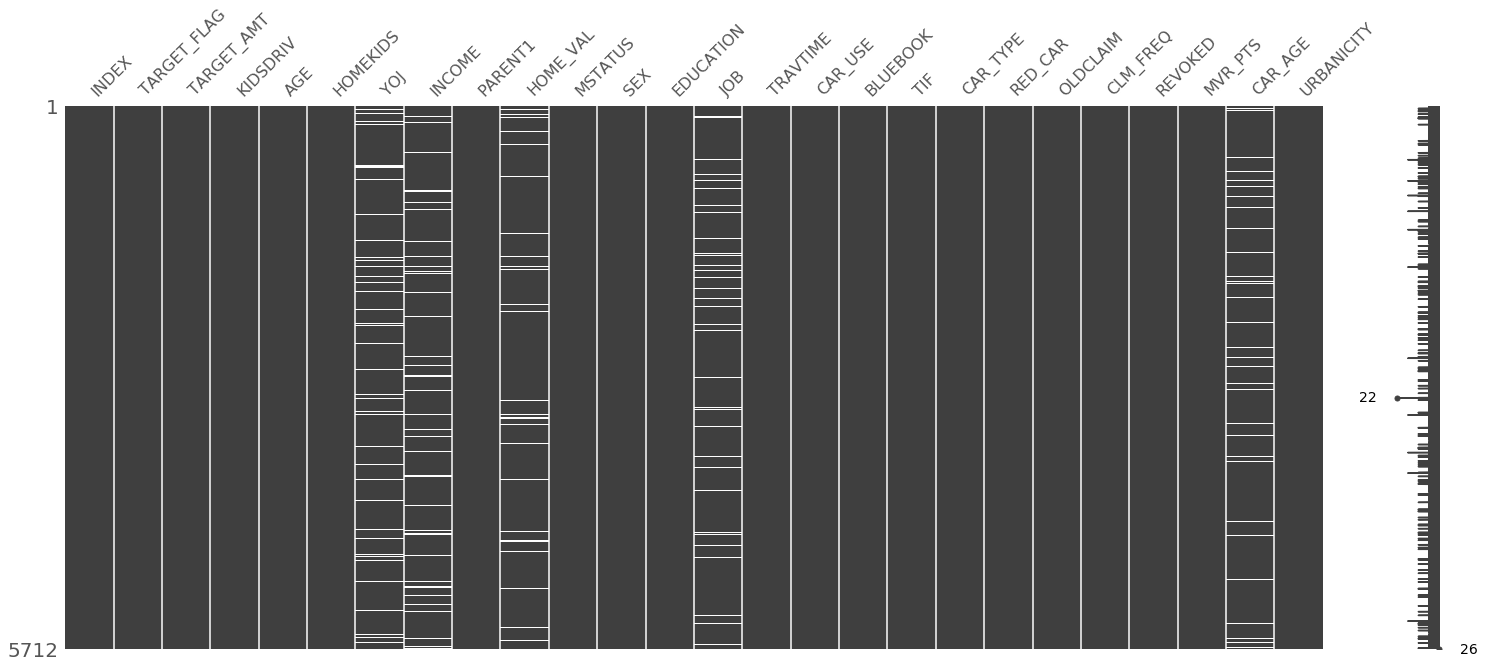

In [57]:
msno.matrix(df_train)

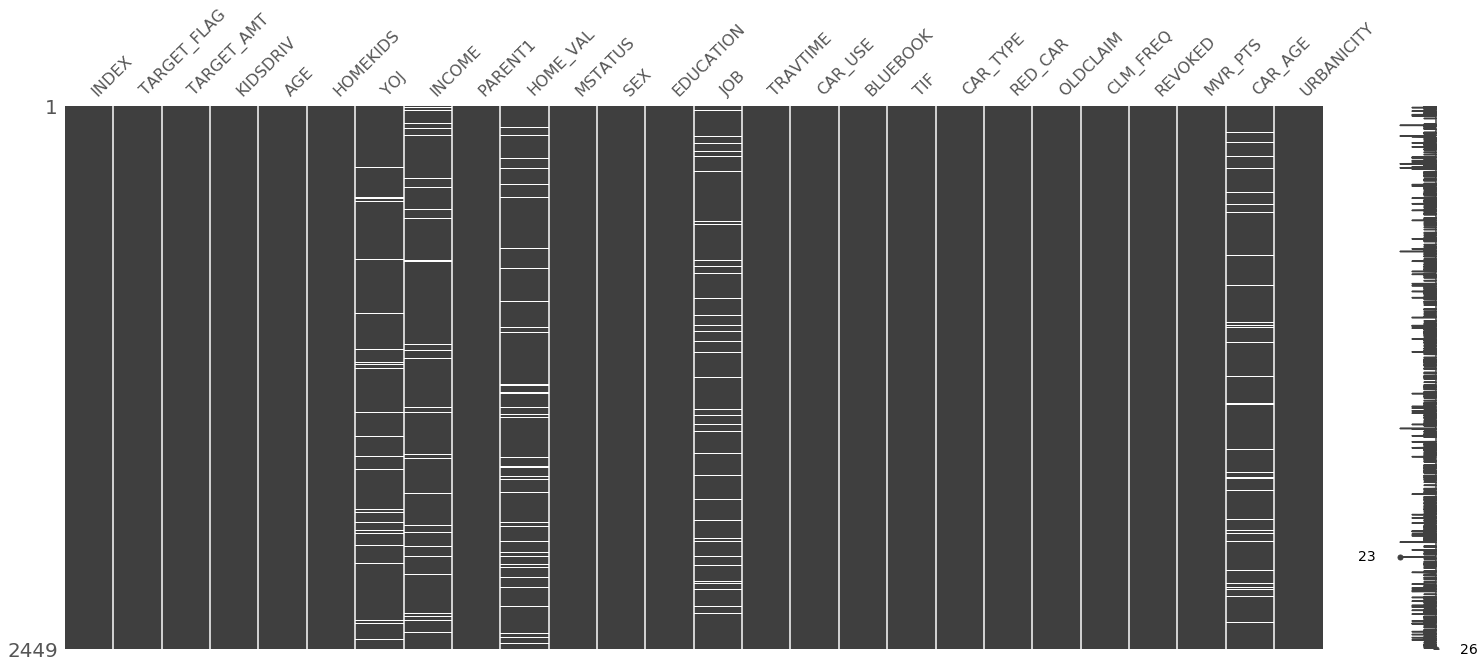

In [58]:
msno.matrix(df_val)

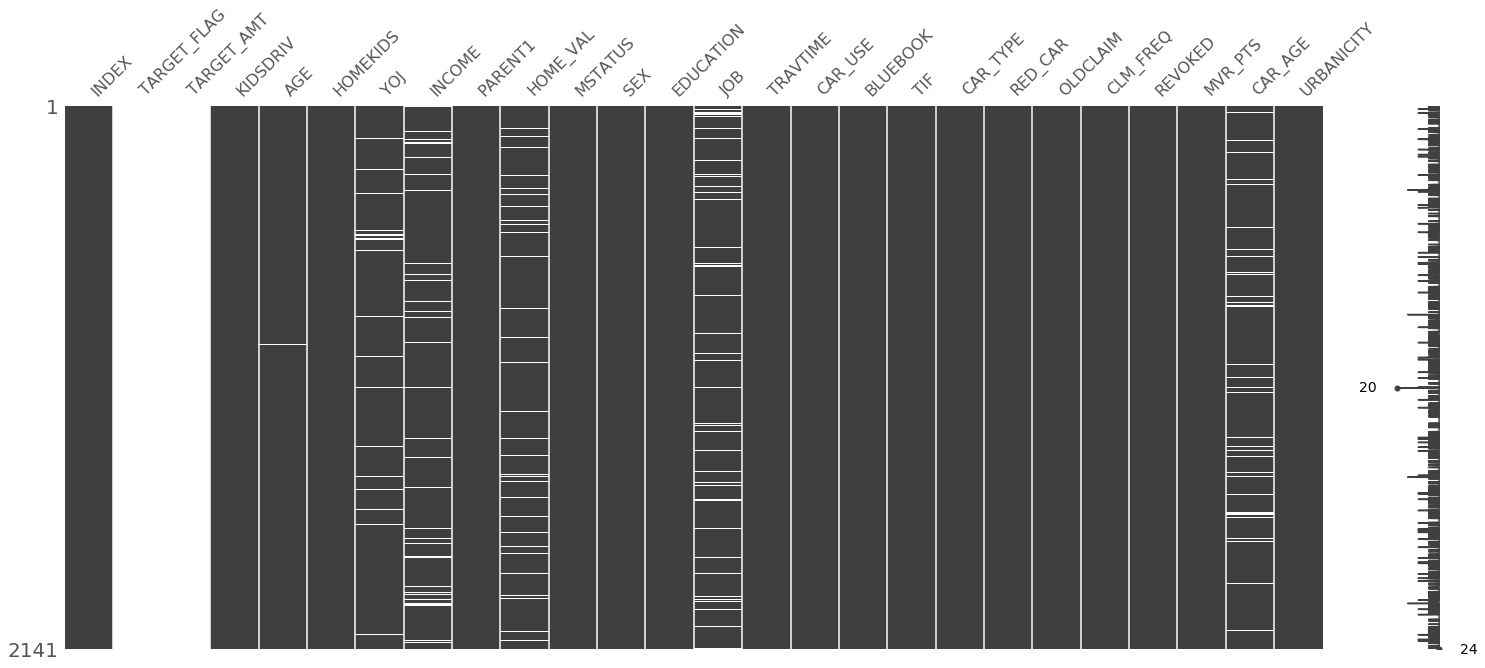

In [59]:
msno.matrix(df_test)

On remarque sur les 3 bases de données ont des valeurs manquantes sur les colonnes 'AGE','YOJ', 'INCOME', 'HOME_VAL','JOB', 'TRAVTIME' et 'CAR_AGE'. Ainsi pour:
- les features quantitatives: INCOME et HOME_VAL, j'ai remplacé ses valeurs manquantes par la moyenne calculée sur la base de données
- les features ordinals: 'AGE','YOJ' et 'CAR_AGE', j'ai remplacé ses valeurs manquantes par la médiane calculée sur la base de données
- les features catégoriques: 'JOB', j'ai remplacé ses valeurs manquantes par une nouvelle classe 'nan'.

Pour la base de données de validation et de test, je remplace les données manquantes par les valeurs calculé sur le train set.

In [60]:
def numerize(price):
    price = price.replace('$','')
    price = price.replace(',', '.')
    return float(price)

for col in ['INCOME', 'HOME_VAL', 'BLUEBOOK','OLDCLAIM']:
    df_train[col]=df_train[col].apply(lambda x: numerize(x) if str(x)!='nan' else x)
    df_val[col]=df_val[col].apply(lambda x: numerize(x) if str(x)!='nan' else x)

C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [61]:
new_values = {}
columns_ = ['AGE','YOJ','INCOME','HOME_VAL','CAR_AGE']
for column in columns_:
    if column in ['INCOME','HOME_VAL']:    
        value = df_train[column].mean()
    else:
        value = df_train[column].median()
    new_values[column] = value
    df_train[column] = df_train[column].fillna(value)
    df_val[column] = df_val[column].fillna(value)
    
df_train = df_train.fillna('nan')
df_val = df_val.fillna('nan')

C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\abdel\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


## Machine Learning models

Dans ce projet, le but est de prédire le TARGET_FLAG donc je n'utilise pas la colonne TARGET_AMT qui est aussi absente dans le test dataset

In [15]:
X_train, y_train = df_train[df_train.columns[3:]], np.array(df_train['TARGET_FLAG'])
X_val, y_val = df_val[df_val.columns[3:]], np.array(df_val['TARGET_FLAG'])


In [16]:
print('Train shape:', X_train.shape)
print('Val shape:',X_val.shape)


Train shape: (5712, 23)
Val shape: (2449, 23)
Test shape: (2141, 23)


In [17]:
print('Train: 0:',list(y_train).count(0), '  1:', list(y_train).count(1))
print('Val: 0:',list(y_val).count(0), '  1:', list(y_val).count(1))

Train: 0: 4207   1: 1505
Val: 0: 1801   1: 648


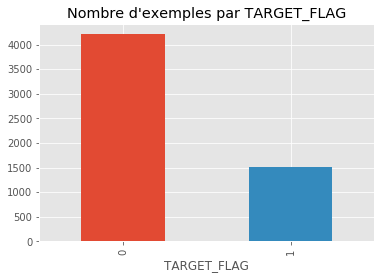

In [18]:
df_train.groupby('TARGET_FLAG').size().plot(kind='bar',title='Nombre d\'exemples par TARGET_FLAG')

- On remarque qu'on a une base de données déséquilibrée, ainsi je vais utiliser le weighted f1_score et la matrice de confusion comme métrique pour comparer les modèles.
- Pour chaque modèle, j'ai utilisé la méthode GridSearch ou RandomizedSearchCV pour trouver les meilleurs hyperparamètres qui donnent les meilleurs résultats sur la base de données de validation.

### Corrélation entre les features 

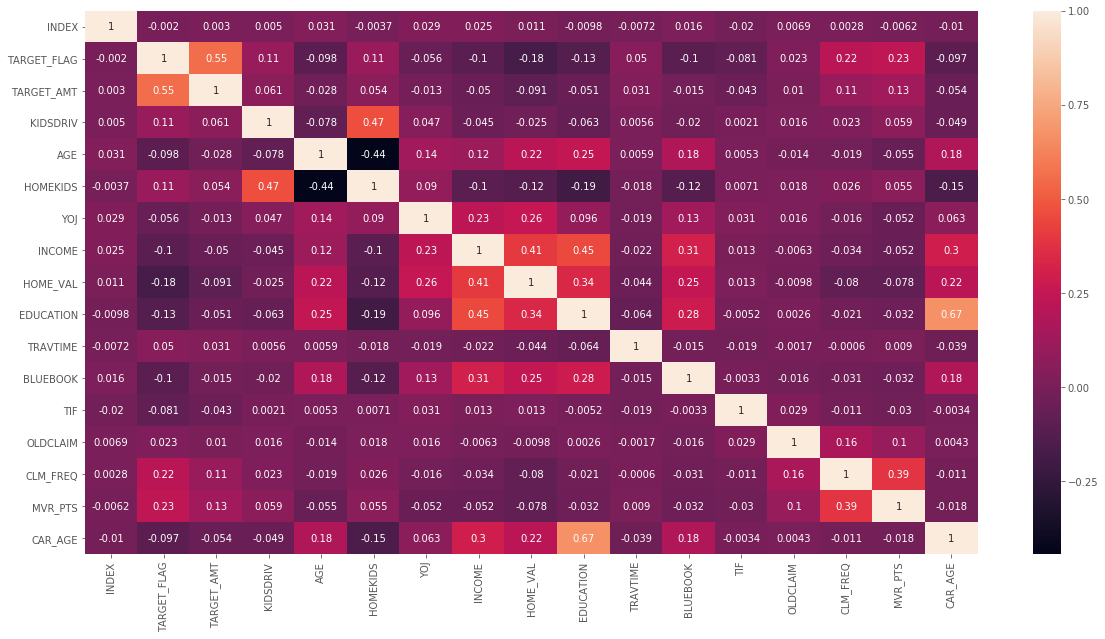

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_train.corr(), annot=True)

On peut voir que il y a des features fortement corrélé

In [20]:
enc = OneHotEncoder(handle_unknown='ignore')
X_train_one_hot = enc.fit_transform(X_train[type_to_col['categorical'][2:]]).toarray()
X_val_one_hot = enc.transform(X_val[type_to_col['categorical'][2:]]).toarray()
X_test_one_hot = enc.transform(X_test[type_to_col['categorical'][2:]]).toarray()

X_train_ = np.concatenate((X_train[list(set(X_train.columns)-set(type_to_col['categorical'][2:]))],
                         X_train_one_hot),axis=1)
X_val_ = np.concatenate((X_val[list(set(X_val.columns)-set(type_to_col['categorical'][2:]))],
                         X_val_one_hot),axis=1)
X_test_ = np.concatenate((X_test[list(set(X_test.columns)-set(type_to_col['categorical'][2:]))],
                         X_test_one_hot),axis=1)

In [21]:
# Normalisation de la base de données
mean, std = np.mean(X_train_, axis=0), np.std(X_train_, axis=0)
X_train_norm = (X_train_-mean)/std
X_val_norm = (X_val_-mean)/std

Dans la suite, je n'utilise la base de données normalisée que pour le modèle de régression logistique et le modèle svm. Il n'y a pas vraiment un intérêt de normaliser la base de données pour un modèle de random forest ou xgboost

In [27]:
from sklearn.model_selection import PredefinedSplit

def f1(y_true,y_pred):
    return f1_score(y_true,y_pred,average = 'weighted')

split_index = np.concatenate([-1*np.ones(len(X_train_)),np.zeros(len(X_val_))])
ps = PredefinedSplit(test_fold=split_index)
X_norm = np.concatenate([X_train_norm,X_val_norm],axis=0)
X = np.concatenate([X_train_,X_val_],axis=0)

y = np.concatenate([y_train,y_val])

scores = {}

### Regréssion logistique

In [28]:
grid_reg = {'C' :[0.1,0.5,1,2,3,4,5,6,7,8,9,10], 'penalty': ['l1','l2'],
        'class_weight':['balanced',None]}

model = LogisticRegression(max_iter=200)
model_ = GridSearchCV(estimator = model, param_grid = grid_reg,scoring=make_scorer(f1),
                      cv=ps,refit=False, verbose=1, n_jobs = 10)

model_.fit(X_norm,y)
print(model_.best_params_)

##### Model with the best hyper parameters
model = LogisticRegression(max_iter=200,**model_.best_params_)
model.fit(X_train_norm,y_train)
y_val_predicted = model.predict(X_val_norm)
scores['reg'] = {'f1': f1(y_val,y_val_predicted), 'acc': accuracy_score(y_val,y_val_predicted)}
print(classification_report(y_val, y_val_predicted))

Fitting 1 folds for each of 48 candidates, totalling 48 fits
{'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1801
           1       0.67      0.40      0.50       648

    accuracy                           0.79      2449
   macro avg       0.74      0.67      0.68      2449
weighted avg       0.77      0.79      0.77      2449



C:\Users\abdel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.73280467        nan 0.76981407        nan 0.73321258
        nan 0.76981407        nan 0.73321258        nan 0.76947009
        nan 0.73321258        nan 0.76947009        nan 0.73321258
        nan 0.76947009        nan 0.73321258        nan 0.76947009
        nan 0.73321258        nan 0.76947009        nan 0.73321258
        nan 0.76947009        nan 0.73321258        nan 0.76947009
        nan 0.73321258        nan 0.76947009        nan 0.73321258
        nan 0.76947009        nan 0.73321258        nan 0.76947009]
  category=UserWarning


### SVM

In [29]:
grid_svm = {'C' :[0.1,0.2,0.5,1,2,3,4,5]}

model = SVC(kernel='linear')
model_ = GridSearchCV(estimator = model, param_grid = grid_svm,scoring=make_scorer(f1),
                      cv = ps, refit = False,verbose=1, n_jobs = 10)
model_.fit(X_norm, y)
print(model_.best_params_)


##### Model with the best hyper parameters
model = SVC(kernel='linear',**model_.best_params_)
model.fit(X_train_norm,y_train)
y_val_predicted = model.predict(X_val_norm)
scores['svm'] = {'f1': f1(y_val,y_val_predicted), 'acc': accuracy_score(y_val,y_val_predicted)}
print(classification_report(y_val, y_val_predicted))


Fitting 1 folds for each of 8 candidates, totalling 8 fits
{'C': 0.1}
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1801
           1       0.69      0.35      0.46       648

    accuracy                           0.79      2449
   macro avg       0.75      0.65      0.66      2449
weighted avg       0.77      0.79      0.76      2449



### Random Forest

In [30]:
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 5)]
max_features = ['auto', 'log2']
max_depth = [int(x) for x in np.linspace(10, 100, num = 6)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [31]:
model = RandomForestClassifier()
model_ = RandomizedSearchCV(estimator = model, param_distributions = grid_rf,scoring=make_scorer(f1),
                            cv = ps, refit=False, verbose=2, n_jobs = -1, n_iter=100)
model_.fit(X,y)
print(model_.best_params_)



##### Model with the best hyper parameters
model = RandomForestClassifier(**model_.best_params_)
model.fit(X_train_,y_train)
y_val_predicted = model.predict(X_val_)
scores['rf'] = {'f1': f1(y_val,y_val_predicted), 'acc': accuracy_score(y_val,y_val_predicted)}
print(classification_report(y_val, y_val_predicted))

Fitting 1 folds for each of 100 candidates, totalling 100 fits
{'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 28, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1801
           1       0.71      0.38      0.50       648

    accuracy                           0.80      2449
   macro avg       0.76      0.66      0.68      2449
weighted avg       0.78      0.80      0.77      2449



### XGBoost

In [32]:
grid_xgb = {
        'n_estimators': n_estimators,
        'learning_rate': [10e-4,5*10e-4,10e-3,5*10e-3,0.01,0.02,0.05,0.1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [33]:
model = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)

model_ = RandomizedSearchCV(estimator = model, param_distributions = grid_xgb,scoring=make_scorer(f1),
                            cv = ps,refit = False,verbose=2, n_jobs = -1, n_iter=100)
model_.fit(X,y)
print(model_.best_params_)



##### Model with the best hyper parameters
model = XGBClassifier(objective='binary:logistic',silent=True, nthread=1,
                      **model_.best_params_)
model.fit(X_train_,y_train)
y_val_predicted = model.predict(X_val_)
scores['xgb'] = {'f1': f1(y_val,y_val_predicted), 'acc': accuracy_score(y_val,y_val_predicted)}
print(classification_report(y_val, y_val_predicted))

Fitting 1 folds for each of 100 candidates, totalling 100 fits
{'subsample': 0.8, 'n_estimators': 1750, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.005, 'gamma': 5, 'colsample_bytree': 0.8}
[02:25:08] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:25:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\abdel\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1801
           1       0.71      0.46      0.55       648

    accuracy                           0.81      2449
   macro avg       0.77      0.69      0.71      2449
weighted avg       0.79      0.81      0.79      2449



### Résultats

In [34]:
pd.DataFrame(scores)

,reg,svm,rf,xgb
acc,0.788893,0.786443,0.795427,0.805635
f1,0.769814,0.759784,0.772591,0.790500


On voit finalement que c'est le modèle XGBoost qui donne les meilleurs scores.

Dans la suite, j'ai essayé d'améliorer ce modèle en essayant une méthode simple de "over sampling" et une méthode de "under sampling" pour voir si ça peut améliorer le modèle.

### Over sampling et Under sampling

In [35]:
def Over_sampler(X_train,y_train):
    nmin = min(np.sum(y_train==0),np.sum(y_train==1))
    argmin = np.argmin((np.sum(y_train==0),np.sum(y_train==1)))
    nmax = max(np.sum(y_train==0),np.sum(y_train==1))
    argmax = np.argmax((np.sum(y_train==0),np.sum(y_train==1)))
    
    samples = X_train[y_train==argmin][np.random.randint(X_train[y_train==argmin].shape[0], size=nmax-nmin), :]
    X_train = np.concatenate((X_train,samples),axis=0)
    y_train = np.concatenate((y_train,np.array([argmin]*(nmax-nmin))),axis=0)
    idxs = np.array(range(len(X_train)))
    print(idxs.shape)
    np.random.shuffle(idxs)
    return X_train[idxs,:], y_train[idxs]

def Under_sampler(X_train,y_train):
    nmin = min(np.sum(y_train==0),np.sum(y_train==1))
    argmin = np.argmin((np.sum(y_train==0),np.sum(y_train==1)))
    nmax = max(np.sum(y_train==0),np.sum(y_train==1))
    argmax = np.argmax((np.sum(y_train==0),np.sum(y_train==1)))
    
    samples = X_train[y_train==argmax][np.random.randint(X_train[y_train==argmax].shape[0], size=nmin), :]
    X_train = np.concatenate((X_train[y_train==argmin],samples),axis=0)
    y_train = np.concatenate((y_train[y_train==argmin],np.array([argmax]*nmin)),axis=0)
    idxs = np.array(range(len(X_train)))
    np.random.shuffle(idxs)
    return X_train[list(idxs)], y_train[list(idxs)]

In [36]:
X_over,y_over = Over_sampler(X_train_,y_train)

print('Train: 0:',list(y_over).count(0), '  1:', list(y_over).count(1))
print('Val: 0:',list(y_val).count(0), '  1:', list(y_val).count(1))

split_index = np.concatenate([-1*np.ones(len(X_over)),np.zeros(len(X_val_))])
ps = PredefinedSplit(test_fold=split_index)
X = np.concatenate([X_over,X_val_],axis=0)
y = np.concatenate([y_over,y_val])

(8414,)
Train: 0: 4207   1: 4207
Val: 0: 1801   1: 648


In [37]:
model = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)

model_ = RandomizedSearchCV(estimator = model, param_distributions = grid_xgb,scoring=make_scorer(f1),
                            cv = ps,refit = False,verbose=2, n_jobs = -1, n_iter=100)
model_.fit(X,y)
print(model_.best_params_)



##### Model with the best hyper parameters
model = XGBClassifier(objective='binary:logistic',silent=True, nthread=1,
                      **model_.best_params_)
model.fit(X_over,y_over)
y_val_predicted = model.predict(X_val_)
scores['xgb_over'] = {'f1': f1(y_val,y_val_predicted), 'acc': accuracy_score(y_val,y_val_predicted)}
print(classification_report(y_val, y_val_predicted))

Fitting 1 folds for each of 100 candidates, totalling 100 fits
{'subsample': 0.8, 'n_estimators': 1750, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 1.0}
[02:29:58] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:29:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\abdel\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1801
           1       0.57      0.66      0.61       648

    accuracy                           0.78      2449
   macro avg       0.72      0.74      0.73      2449
weighted avg       0.79      0.78      0.78      2449



In [38]:
X_under,y_under = Under_sampler(X_train_,y_train)

print('Train: 0:',list(y_over).count(0), '  1:', list(y_over).count(1))
print('Val: 0:',list(y_val).count(0), '  1:', list(y_val).count(1))

split_index = np.concatenate([-1*np.ones(len(X_under)),np.zeros(len(X_val_))])
ps = PredefinedSplit(test_fold=split_index)
X = np.concatenate([X_under,X_val_],axis=0)
y = np.concatenate([y_under,y_val])

Train: 0: 4207   1: 4207
Val: 0: 1801   1: 648


In [39]:
model = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)

model_ = RandomizedSearchCV(estimator = model, param_distributions = grid_xgb,scoring=make_scorer(f1),
                            cv = ps,refit = False,verbose=2, n_jobs = -1, n_iter=100)
model_.fit(X,y)
print(model_.best_params_)



##### Model with the best hyper parameters
model = XGBClassifier(objective='binary:logistic',silent=True, nthread=1,
                      **model_.best_params_)
model.fit(X_under,y_under)
y_val_predicted = model.predict(X_val_)
scores['xgb_under'] = {'f1': f1(y_val,y_val_predicted), 'acc': accuracy_score(y_val,y_val_predicted)}
print(classification_report(y_val, y_val_predicted))

Fitting 1 folds for each of 100 candidates, totalling 100 fits
{'subsample': 0.8, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.8}
[02:31:59] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:31:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\abdel\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1801
           1       0.51      0.77      0.61       648

    accuracy                           0.74      2449
   macro avg       0.70      0.75      0.71      2449
weighted avg       0.79      0.74      0.75      2449



In [40]:
pd.DataFrame(scores)

,reg,svm,rf,xgb,xgb_over,xgb_under
acc,0.788893,0.786443,0.795427,0.805635,0.776235,0.741527
f1,0.769814,0.759784,0.772591,0.790500,0.781544,0.754742


Finalement, les méthodes de rééchantillonnage utilisées n'améliorent pas le modèle. 

In [41]:
### Entrainement du meilleur modèle

model = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)

model_ = RandomizedSearchCV(estimator = model, param_distributions = grid_xgb,scoring=make_scorer(f1),
                            cv = ps,refit = False,verbose=2, n_jobs = -1, n_iter=100)
model_.fit(X,y)
print(model_.best_params_)



##### Model with the best hyper parameters
model = XGBClassifier(objective='binary:logistic',silent=True, nthread=1,
                      **model_.best_params_)
model.fit(X_train_,y_train)

Fitting 1 folds for each of 100 candidates, totalling 100 fits
{'subsample': 1.0, 'n_estimators': 1750, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.8}
[09:27:11] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:27:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\abdel\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=1750, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

## Prédiction sur la base de données test

D'abord j'utilise les mêmes transformations utilisées sur la base de données de validation et puis j'utilise le modèle XGBoost pour faire la prédiction

In [42]:
df_test = pd.read_csv('test_auto.csv')
df_test['EDUCATION'] = df_test['EDUCATION'].apply(lambda x: education_to_num[x] if x in education_to_num.keys() else x )
for col in ['INCOME', 'HOME_VAL', 'BLUEBOOK','OLDCLAIM']:
    df_test[col]=df_test[col].apply(lambda x: numerize(x) if str(x)!='nan' else x)
    
columns_ = ['AGE','YOJ','INCOME','HOME_VAL','CAR_AGE']
for column in columns_:
    df_test[column] = df_test[column].fillna(new_values[column])
    
df_test = df_test.fillna('nan')

X_test = df_test[df_test.columns[3:]]
print('Test shape:',X_test.shape)

X_test_one_hot = enc.transform(X_test[type_to_col['categorical'][2:]]).toarray()

X_test_ = np.concatenate((X_test[list(set(X_test.columns)-set(type_to_col['categorical'][2:]))],
                         X_test_one_hot),axis=1)

Test shape: (2141, 23)


In [43]:
y_test_predicted = model.predict(X_test_)

In [47]:
df_test = pd.read_csv('test_auto.csv')
df_test['TARGET_FLAG'] = y_test_predicted
df_test.to_csv('test_auto_prediction.csv',index=False)